In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import catboost as ctb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# Data Preparation

In [ ]:
#Data Inti
data = pd.read_csv('sampling_healtkathon2022.csv')
#Data Procedure
proc = pd.read_csv('sampling_healthkathon2022_procedure.csv')
#Data Diagnosa
diag = pd.read_csv('sampling_healthkathon2022_diagnosa.csv')

In [ ]:
# data validasi 
data_val = pd.read_csv('sampling3_healthkathon2022_sep.csv', sep = ';')
proc_val = pd.read_csv('sampling3_healthkathon2022_procedure.csv', sep = ';')
diag_val = pd.read_csv('sampling3_healthkathon2022_diagnosa.csv', sep = ';')

# Data Cleaning

### Data Inti

In [ ]:
#melihat info singkat data inti
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401882 entries, 0 to 11401881
Data columns (total 22 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   id_peserta   int64  
 2   dati2        int64  
 3   typefaskes   object 
 4   usia         int64  
 5   jenkel       object 
 6   pisat        float64
 7   tgldatang    object 
 8   tglpulang    object 
 9   jenispel     int64  
 10  politujuan   object 
 11  diagfktp     object 
 12  biaya        float64
 13  jenispulang  float64
 14  cbg          object 
 15  kelasrawat   int64  
 16  kdsa         object 
 17  kdsp         object 
 18  kdsr         object 
 19  kdsi         object 
 20  kdsd         object 
 21  label        int64  
dtypes: float64(3), int64(7), object(12)
memory usage: 1.9+ GB


In [ ]:
#Hapus kolom yang tidak dibutuhkan, simpan pada variabel baru
data2 = data.drop(columns = ['id_peserta', 'typefaskes', 'usia', 'jenkel', 'pisat', 'jenispel',
                            'jenispulang', 'cbg','kdsp', 'kdsr', 'kdsi',
                            'kdsd', 'kdsa', 'kelasrawat', 'jenispel', 'diagfktp'])

In [ ]:
# Informasi singkat mengenai data2
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401882 entries, 0 to 11401881
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   dati2       int64  
 2   tgldatang   object 
 3   tglpulang   object 
 4   politujuan  object 
 5   biaya       float64
 6   label       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 608.9+ MB


In [ ]:
# menampilkan 5 data teratas
data2.head()

,id,dati2,tgldatang,tglpulang,politujuan,biaya,label
0,165666,17,2018-07-25T17:00:00.000Z,2018-07-25T17:00:00.000Z,THT,184300.0,0
1,1010828,17,2019-05-27T17:00:00.000Z,2019-05-30T17:00:00.000Z,NaN,10628400.0,0
2,166042,17,2019-07-16T17:00:00.000Z,2019-07-16T17:00:00.000Z,INT,187300.0,0
3,168937,17,2019-10-17T17:00:00.000Z,2019-10-17T17:00:00.000Z,MAT,187300.0,0
4,1005899,17,2018-04-18T17:00:00.000Z,2018-04-18T17:00:00.000Z,SAR,381600.0,0


###### Cek nilai yang hilang

In [ ]:
# Mengecek jumlah nilai yang hilang
data2.isna().sum()

id                  0
dati2               0
tgldatang           0
tglpulang           0
politujuan    4041455
biaya           57815
label               0
dtype: int64

In [ ]:
# Cek median dari fitur biaya
data['biaya'].median()

287200.0

In [ ]:
# Ganti nilai yang hilang pada kolom politujuan dengan N
data2['politujuan'].fillna('N', inplace = True)

# Ganti nilai yang hilang pada kolom biaya dengan median dari kolom biaya
data2['biaya'].fillna(data2['biaya'].median(), inplace=True)

In [ ]:
# Cek kembali data yang hilang
data2.isna().sum()

id            0
dati2         0
tgldatang     0
tglpulang     0
politujuan    0
biaya         0
label         0
dtype: int64

###### Ubah tipe data

In [ ]:
#Ubah tipe data ke bentuk yang ukurannya lebih kecil
data2['label'] = data2[['label']].astype('int8')
data2['dati2'] = data2[['dati2']].astype('int16')
data2['id'] = data2['id'].astype('int32')
data2['biaya'] = data2['biaya'].astype('int32')

### Procedure

In [ ]:
# Hapus data yang mengandung abjad pada kolom proc 
proc = proc[~proc['proc'].str.contains("[a-zA-Z]").fillna(False)]

# Ambil 2 angka pertama pada kolom proc dan simpan pada kolom cat
proc['cat'] = proc['proc'].str[:2] 

# Hapus data yang hanya mengandung '-'
cond = proc['cat'] == '-'
proc = proc[~cond]

In [ ]:
# Menampilkan 5 data pertama
proc.head()

,id,proc,cat
0,6,90.59,90
1,6,69.01,69
2,6,88.78,88
3,27,90.59,90
4,27,88.78,88


In [ ]:
#Mengubah tipe data ke ukuran yang lebih kecil
proc['cat'] = proc['cat'].astype('int8')

#ambil kolom id dan cat, simpan pada variabel baru
proc2 = proc[['id', 'cat']]

In [ ]:
# Gabung kategori pada kolom cat menjadi 1 baris berdasarkan id yang sama
proc2 = proc2.groupby('id').aggregate(
    lambda x: ', '.join(map(str, set(x)))).reset_index()

In [ ]:
#Menampilkan 10 data pertama
proc2.head(10)

,id,cat
0,1,"90, 87"
1,3,90
2,4,90
3,5,90
4,6,"88, 90, 69"
5,7,"88, 90, 69"
6,8,"90, 86"
7,9,90
8,10,90
9,11,"88, 90, 93"


### Diagnosa

In [ ]:
# 5 data pertama pada diagnosa
diag.head()

,id,diag,levelid
0,6,O06.9,1
1,57,J02.9,1
2,91,R10.1,1
3,109,R18,1
4,111,N81.3,1


In [ ]:
diag[diag['diag'].str.len() >  5]

,id,diag,levelid
95,847,M19.96,1
217,2129,M10.99,2
258,2415,M86.87,1
264,2500,M54.56,1
266,2517,M71.25,1
...,...,...,...
17308297,11424801,S82.30,1
17308313,11424978,S72.00,1
17308316,11425031,M86.57,1
17308382,11425570,M08.08,1


In [ ]:
# Ambil data yang mengandung huruf Abjad
diag = diag[diag['diag'].str.contains("[a-zA-Z]").fillna(False)]
# Ambil 3 kode pertama pada diagnosis
diag['diag2'] = diag['diag'].str[:3] 

In [ ]:
# Menampilkan 5 data pertama
diag.head()

,id,diag,levelid,diag2
0,6,O06.9,1,O06
1,57,J02.9,1,J02
2,91,R10.1,1,R10
3,109,R18,1,R18
4,111,N81.3,1,N81


In [ ]:
# Mengubah semua abjad pada kolom diag2 menjadi huruf besar
diag['diag2'] = diag['diag2'].str.upper()

In [ ]:
# Simpan kolom id, diag2, dan levelid pada diag2
diag2 = diag[['id', 'diag2', 'levelid']]

In [ ]:
# Hapus duplikat pada diag2
diag2 = diag2.drop_duplicates()

In [ ]:
# Gabung kategori pada kolom diag2 menjadi 1 baris berdasarkan id yang sama
diag2 = diag2.groupby('id').aggregate(lambda x: ', '.join(map(str, set(x)))).reset_index()

In [ ]:
# Preview 5 data pertama
diag2.head()

,id,diag2,levelid
0,1,J98,1
1,2,H52,1
2,3,A16,1
3,4,M54,1
4,5,K30,1


#  Exploratory Data Analysis

In [ ]:
# Menghitung jumlah tiap label
jml_label = data2['label'].value_counts().reset_index()
#mengubah label menjadi string
jml_label['index'] = jml_label['index'].astype(str)

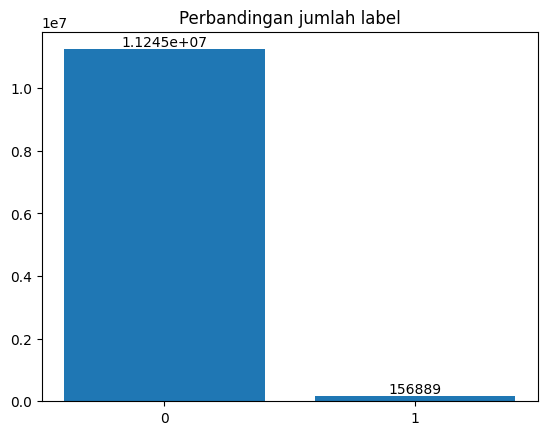

In [ ]:
fig, ax = plt.subplots()

#memplotkan jumlah label
ax.bar(jml_label['index'], jml_label['label'])
ax.set_title('Perbandingan jumlah label')
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
# hitung mean, max, min, dan median dari biaya berdasarkan label
biaya_info = data2.groupby('label').agg({'biaya' : ['mean', 'max', 'min', 'median']})
#hapus multiindex pada kolom
biaya_info.columns = biaya_info.columns.droplevel(0)
# reset index baris
biaya_info = biaya_info.reset_index()
#mengubah label menjadi string
biaya_info['label'] = biaya_info['label'].astype(str)

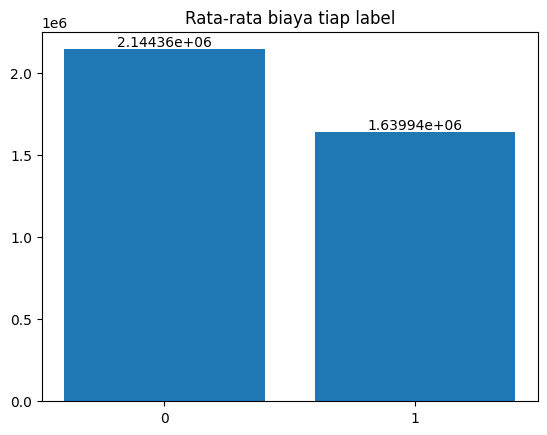

In [ ]:
fig,  ax = plt.subplots()

#plotkan rata-rata biaya
ax.bar(biaya_info['label'], biaya_info['mean'])
ax.set_title('Rata-rata biaya tiap label')
ax.bar_label(ax.containers[0])
plt.show()

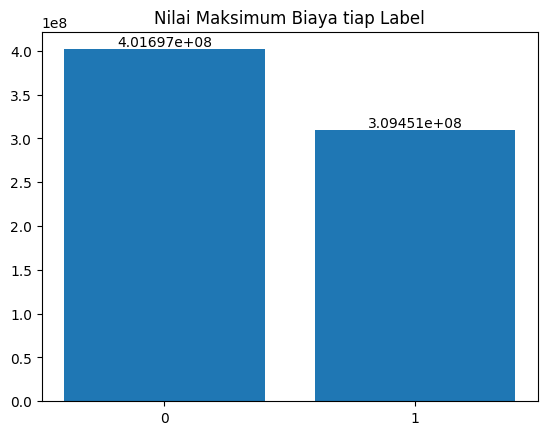

In [ ]:
fig,  ax = plt.subplots()

#plot biaya maksimum dalam data
ax.bar(biaya_info['label'], biaya_info['max'])
ax.set_title('Nilai Maksimum Biaya tiap Label')
ax.bar_label(ax.containers[0])
plt.show()

# Feature Engineering

### Data Inti

###### berisi jumlah hari pasien dirawat

In [ ]:
#Fungsi untuk mengubah data ke format datetime
def to_dt(data, kolom):
    return pd.to_datetime(data[kolom], infer_datetime_format = True)

In [ ]:
# ubah format tglpulang dan tgldatang ke bentuk datetime
data2['tgp'] = to_dt(data2, 'tglpulang')
data2['tgd'] = to_dt(data2, 'tgldatang')

#Lakukan pengurangan tglpulang - tgldatang untuk menghitung jumlah hari
data2['hari'] = data2['tgp'] - data2['tgd']

# Pastikan kolom hari bertipe string/object
data2['hari'] = data2['hari'].astype(str)

# hapus kata 'days' pada kolom hari
data2['hari'] = data2['hari'].str.strip('days')

#Ubah tipe data hari menjadi int16 untuk menghemat penggunaan memory
data2['hari'] = data2['hari'].astype('int16')

In [ ]:
#Hapus kolom yang sudah tidak dibutuhkan
data2 = data2.drop(columns = ['tglpulang', 'tgldatang', 'tgd', 'tgp'])

In [ ]:
# info singkat data2 setelah penambahan fitur hari
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401882 entries, 0 to 11401881
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          int32 
 1   dati2       int16 
 2   politujuan  object
 3   biaya       int32 
 4   label       int8  
 5   hari        int16 
dtypes: int16(2), int32(2), int8(1), object(1)
memory usage: 228.3+ MB


###### Labeling Poli Tujuan

In [ ]:
# Fungsi untuk melakukan labeling pada kolom univalue yang bertipe string
def labeling_uni(data, val):
    boolean = []
    for i in data:
        if i == val:
            boolean.append(1)
        else:
            boolean.append(0)
    return boolean

In [ ]:
# Labeling politujuan yang sering terjadi inefisiensi
# subsetting data berlabel 1
label1 = data2[data2['label'] == 1]
# hitung jumlah masing-masing politujuan pada data 
poli_label1 = label1['politujuan'].value_counts().reset_index()
# filter politujuan yang muncul di lebih dari 250 kunjungan
poli_more2000 = poli_label1[poli_label1['politujuan'] > 2000]
# 'index' = nama politujuan, jadikan sebagai list
poli_more2000 = poli_more2000['index'].values

In [ ]:
poli_label1[poli_label1['politujuan'] > 2000]

,index,politujuan
0,N,53563
1,IGD,20800
2,MAT,14228
3,INT,11375
4,BED,9402
5,ANA,7753
6,SAR,6556
7,JIW,6193
8,OBG,3672
9,JAN,3274


In [ ]:
data_poli_inti = data[['id', 'politujuan']]
data_poli_inti['politujuan'].fillna('N', inplace = True)

In [ ]:
data_poli_inti.head()

,id,politujuan
0,165666,THT
1,1010828,N
2,166042,INT
3,168937,MAT
4,1005899,SAR


In [ ]:
# Lakukan labeling pada politujuan
for i in poli_more2000:
    data_poli_inti[i] = labeling_uni(data_poli_inti['politujuan'], i)

In [ ]:
# Preview 5 data pertama setelah dilakukan labeling
data_poli_inti.head()

,id,politujuan,N,IGD,MAT,INT,BED,ANA,SAR,JIW,OBG,JAN,THT,IRM,KLT
0,165666,THT,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1010828,N,1,0,0,0,0,0,0,0,0,0,0,0,0
2,166042,INT,0,0,0,1,0,0,0,0,0,0,0,0,0
3,168937,MAT,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1005899,SAR,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Hapus kolom politujuan dan id
data_poli_inti = data_poli_inti.drop(columns = ['politujuan', 'id'])

#Preview 5 data pertama setelah kolom dihapus
data_poli_inti.head()

,N,IGD,MAT,INT,BED,ANA,SAR,JIW,OBG,JAN,THT,IRM,KLT
0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# ubah tipe data semua hasil dummy variabel menjadi int8 untuk menghemat penggunaan memory
data_poli_inti = data_poli_inti.iloc[:,:].astype('int8')

In [ ]:
# Gabungkan data2 (inti) dengan data hasil labeling pada politujuan
data3 = data2.merge(data_poli_inti, left_index = True, right_index = True)

# preview setelah merging
data3.head()

,id,dati2,politujuan,biaya,label,hari,N,IGD,MAT,INT,BED,ANA,SAR,JIW,OBG,JAN,THT,IRM,KLT
0,165666,17,THT,184300,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1010828,17,N,10628400,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
2,166042,17,INT,187300,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,168937,17,MAT,187300,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1005899,17,SAR,381600,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Nilai pada data yang kosong akibat merging diisi dengan angka 0
data4 = data3.iloc[:, 6:].fillna(0)

# Ubah tipe data ke ukuran yang lebih kecil
data4 = data4.iloc[:, :].astype('int8')

#preview data setelah dibenarkan
data4.head()

,N,IGD,MAT,INT,BED,ANA,SAR,JIW,OBG,JAN,THT,IRM,KLT
0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Gabungkan data2 (inti) dengan hasil labeling politujuan berdasarkan index
data2 = data2.merge(data4, left_index = True, right_index = True)

In [ ]:
# hapus kolom politujuan
data2 = data2.drop(columns = 'politujuan')

# preview 5 data teratas
data2.head()

,id,dati2,biaya,label,hari,N,IGD,MAT,INT,BED,ANA,SAR,JIW,OBG,JAN,THT,IRM,KLT
0,165666,17,184300,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1010828,17,10628400,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
2,166042,17,187300,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,168937,17,187300,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1005899,17,381600,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


###### Simpan data berisi id dan label saja untuk labeling data selanjutnya

In [ ]:
# simpan data inti yang tidak memiliki duplikat pada variabel dproc
dproc = data.drop_duplicates()
# variabel dproc hanya akan menyimpan id dan label
dproc = dproc[['id', 'label']]
dproc.head()

,id,label
0,165666,0
1,1010828,0
2,166042,0
3,168937,0
4,1005899,0


### Procedure

In [ ]:
# Gabungkan data proc dan dproc berdasarkan id dengan left join
lproc = proc.merge(dproc,  how = 'left', on = 'id')
lproc.head()

,id,proc,cat,label
0,6,90.59,90,0.0
1,6,69.01,69,0.0
2,6,88.78,88,0.0
3,27,90.59,90,0.0
4,27,88.78,88,0.0


In [ ]:
# Lakukan labeling berdasarkan procedure yang paling banyak terjadi inefisiensi
# filter lproc yang berlabel 1
l1proc = lproc[lproc['label'] == 1]

# Hitung jumlah data dari setiap procedure yang berlabel 1
most_inf = l1proc['cat'].value_counts()
# Reset index data series untuk mengembalikan kolom tipe procedure
most_inf = most_inf.reset_index()

most_inf.head()

,index,cat
0,99,26634
1,89,19288
2,90,18755
3,93,15040
4,95,14761


In [ ]:
most_inf.columns = ['procedure', 'sum']
most_inf

,procedure,sum
0,99,26634
1,89,19288
2,90,18755
3,93,15040
4,95,14761
...,...,...
94,32,6
95,52,4
96,19,4
97,43,4


In [ ]:
# Filter procedure yang jumlahnya lebih dari 500
more_1000 = most_inf[most_inf['sum'] > 1000]
more_1000['procedure'].values

array([99, 89, 90, 93, 95, 88, 87, 86, 94, 96, 13, 73, 39, 91, 57],
      dtype=int64)

In [ ]:
# Fungsi untuk mengubah kolom multivalue menjadi bentuk list
def multi_to_list(data):
    value = []
    for i in data:
        yes = [ x.lstrip() for x in i.split(',')] # split data yang dipisahkan koma menjadi list 
        value.append(yes)
    return value

In [ ]:
# Ubah kolom 'cat' pada proc2 (data procedure yang sudah dilakukan cleaning) menjadi sebuah list
catproc_l = multi_to_list(proc2['cat'])
# 5 list pertama
catproc_l[:5]

[['90', '87'], ['90'], ['90'], ['90'], ['88', '90', '69']]

In [ ]:
# ubah procedure pada more_500 menjadi bentuk list/array
more_1000_proc = more_1000['procedure'].astype('int8').values
more_1000_proc

array([99, 89, 90, 93, 95, 88, 87, 86, 94, 96, 13, 73, 39, 91, 57],
      dtype=int8)

In [ ]:
# Fungsi untuk melakukan labeling pada kolom proc yang berisi multivalue
def labeling(data, val):
    boolean = list()
    for i in data:
        decision = 0
        for x in i:
            if int(x) == val:
                decision = 1
                break
        boolean.append(decision)
    return boolean

In [ ]:
# Lakukan labeling berdasarkan procedure yang telah difilter sebelumnya
for i in more_1000_proc:
    proc2[str(i)] = labeling(catproc_l, i)

In [ ]:
# hapus kolom 'cat' dan simpan pada variabel baru
proc_fix = proc2.drop(columns = 'cat')

In [ ]:
proc_fix.head()

,id,99,89,90,93,95,88,87,86,94,96,13,73,39,91,57
0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


### Diagnosa

In [ ]:
# Kita akan memakai dproc kembali
dproc.head() 

,id,label
0,165666,0
1,1010828,0
2,166042,0
3,168937,0
4,1005899,0


In [ ]:
# ambil kolom id dan diag2 pada data diag dan simpan ke variabel baru
ldiag = diag[['id', 'diag2']] # diag merupakan data diagnosa sebelum dijadikan multivalue

#gabung ldiag dengan dproc berdasarkan id dengan left join
ldiag = ldiag.merge(dproc, on = 'id', how = 'left')
ldiag.head()

,id,diag2,label
0,6,O06,0.0
1,57,J02,0.0
2,91,R10,0.0
3,109,R18,0.0
4,111,N81,1.0


In [ ]:
# Cari diagnosa yang paling banyak terjadi inefisiensi
# Filter ldiag yang berlabel 1
l1diag = ldiag[ldiag['label'] == 1]

# Hitung jumlah data dari setiap procedure yang berlabel 1 dan reset index-nya
inf_diag = l1diag[['diag2']].value_counts().reset_index()

In [ ]:
# Filter diagnosa yang muncul di lebih dari 2000 pasien
more_2000 = inf_diag[inf_diag[0] > 2000]
more_2000

,diag2,0
0,P03,13219
1,H52,8112
2,E11,5671
3,K30,4716
4,Z09,4197
5,D56,4106
6,D64,3925
7,I10,3605
8,I50,3576
9,F20,3447


In [ ]:
# Ubah diagnosa yang telah difilter ke bentuk list
more_2000_diag = more_2000['diag2'].values
more_2000_diag

array(['P03', 'H52', 'E11', 'K30', 'Z09', 'D56', 'D64', 'I10', 'I50',
       'F20', 'Z38', 'R50', 'N18', 'H25', 'P59', 'Z37', 'H26', 'I25',
       'M54', 'R10', 'L02'], dtype=object)

###### labeling pada diag2 dan levelid

In [ ]:
# ubah kolom diag2 dan levelid menjadi list
diag_list = multi_to_list(diag2['diag2'])
level = multi_to_list(diag2['levelid'])

In [ ]:
# Fungsi untuk melakukan labeling pada kolom multivalue yang bertipe string
def labeling_str(data, val):
    boolean = list()
    for i in data:
        decision = 0 #decision untuk memberikan label 0/1
        for x in i:
            if x == val: 
                decision = 1 #jika x adalah val, maka decision menjadi 1
                break #berhenti looping
        boolean.append(decision) #tambahkan hasil decision ke list boolean
    return boolean

In [ ]:
# Beri label pada diagnosa berdasarkan diag2 yang telah difilter
for i in more_2000_diag:
    diag2[i] = labeling_str(diag_list, i)

In [ ]:
# 5 data teratas setelah labeling diagnosa
diag2.head()

,id,diag2,levelid,P03,H52,E11,K30,Z09,D56,D64,...,R50,N18,H25,P59,Z37,H26,I25,M54,R10,L02
0,1,J98,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,H52,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,A16,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,M54,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,K30,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Simpan fungsi ke dalam variabel
enc = MultiLabelBinarizer()

# memberi label pada levelid dengan fungsi multilabelbinarizer
enc.fit(level)
level_label = pd.DataFrame(enc.transform(level), columns=enc.classes_)

# Menampilkan data teratas pada level_label
level_label.head()

,1,2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [ ]:
# Gabungkan hasil labeling dengan diag2
diag3 = diag2.merge(level_label, right_index = True, left_index = True)

In [ ]:
# Hapus kolom diag2 dan levelid
diag3 = diag3.drop(columns = ['diag2', 'levelid'])

# Menampilkan data 5 teratas
diag3.head()

,id,P03,H52,E11,K30,Z09,D56,D64,I10,I50,...,H25,P59,Z37,H26,I25,M54,R10,L02,1,2
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# gabungkan data inti, procedure dan diagnosa yang telah dilakukan cleaning dan feature engineering
data3 = data2.merge(proc_fix, on = 'id', how = 'left') \
        .merge(diag3, on = 'id', how = 'left')

# Menampilkan data teratas
data3.head()

,id,dati2,biaya,label,hari,N,IGD,MAT,INT,BED,...,H25,P59,Z37,H26,I25,M54,R10,L02,1,2
0,165666,17,184300,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1010828,17,10628400,0,3,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,166042,17,187300,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,168937,17,187300,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1005899,17,381600,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Nilai pada data yang kosong akibat merging diisi dengan angka 0
data4 = data3.iloc[:, 6:].fillna(0)

# Ubah tipe data ke ukuran yang lebih kecil
data4 = data4.iloc[:, :].astype('int8')

In [ ]:
# Simpan 6 kolom pertama pada data gabungan sebelumnya
data5 = data3.iloc[:, :6]

In [ ]:
# Gabungkan kembali data tersebut
data5 = data5.merge(data4, left_index = True, right_index = True)

#menampilkan 5 data teratas
data5.head()

,id,dati2,biaya,label,hari,N,IGD,MAT,INT,BED,...,H25,P59,Z37,H26,I25,M54,R10,L02,1,2
0,165666,17,184300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1010828,17,10628400,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,166042,17,187300,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,168937,17,187300,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1005899,17,381600,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Modeling

In [ ]:
# Hapus fitur yang bukan termasuk kategori
cat = data5.drop(columns = ['id', 'biaya', 'label', 'hari'])

# Jadikan nama kategori ke dalam bentuk list / array
feature = cat.columns.values

# Hasil
feature

array(['dati2', 'N', 'IGD', 'MAT', 'INT', 'BED', 'ANA', 'SAR', 'JIW',
       'OBG', 'JAN', 'THT', 'IRM', 'KLT', '99', '89', '90', '93', '95',
       '88', '87', '86', '94', '96', '13', '73', '39', '91', '57', 'P03',
       'H52', 'E11', 'K30', 'Z09', 'D56', 'D64', 'I10', 'I50', 'F20',
       'Z38', 'R50', 'N18', 'H25', 'P59', 'Z37', 'H26', 'I25', 'M54',
       'R10', 'L02', '1', '2'], dtype=object)

In [ ]:
# Simpan data selain kolom label dan id ke variabel X1 dan kolom label ke y1
X1 = data5.drop(columns = ['id','label'])
y1 =  data5['label']

In [ ]:
# Buat data train dan data test
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=32, stratify = y1)

In [ ]:
# Gabungkan data train sebelum melakukan resampling
X_train['label'] = y_train

# Preview setelah digabungkan
X_train.head()

,dati2,biaya,hari,N,IGD,MAT,INT,BED,ANA,SAR,...,P59,Z37,H26,I25,M54,R10,L02,1,2,label
139526,90,193500,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2607926,133,190400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7665215,187,377100,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5004434,17,6487200,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
750475,195,2266400,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
# Pisahkan data yang berlabel 0 dan 1
X_train1 = X_train[X_train['label'] == 1]
X_train0 = X_train[X_train['label'] == 0]

In [ ]:
# Lakukan random undersampling dengan melakukan resampling pada kelas mayoritas (label 0)
resampled_train0 = X_train0.sample(2000000, random_state = 15)

# Dimensi setelah kelas mayoritas diambil secara acak
resampled_train0.shape

(2000000, 55)

In [ ]:
# Gabungkan kembali data berlabel 0 dan 1
X_train_resampled = pd.concat([resampled_train0, X_train1])

# Dimensi setelah menggabungkan data berlabel 0 dan 1
X_train_resampled.shape

(2125511, 55)

In [ ]:
# Bagi data train yang telah dilakukan resampling ke bentuk X_train dan y_train kembali
X_train = X_train_resampled.drop(columns = 'label')
y_train = X_train_resampled['label']

In [ ]:
# set untuk dilakukan evaluasi pada data training
#eval_set = [(X_test, y_test)]

# Definisikan model dan atur parameter pada model yang digunakan
ct_clas = ctb.CatBoostClassifier(verbose=False,random_state=0,
                                objective = 'Logloss')

In [ ]:
# Lakukan fitting model ke data train
ct_clas.fit(X_train, y_train, verbose = False, cat_features = feature)

# Evaluation

In [ ]:
# prediksi data test berdasarkan data training
preds = ct_clas.predict(X_test)

In [ ]:
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2248999
           1       0.66      0.53      0.58     31378

    accuracy                           0.99   2280377
   macro avg       0.83      0.76      0.79   2280377
weighted avg       0.99      0.99      0.99   2280377



In [ ]:
print(confusion_matrix(y_test, preds))

[[2240428    8571]
 [  14883   16495]]


###### Menyimpan Model

In [ ]:
# Simpan model ct_clas dalam bentuk pickle
pickle.dump(ct_clas, open('bpjs_final_model.sav', 'wb'))

###### Load Model

In [ ]:
#Load model ketika ingin digunakan
final_model = pickle.load(open('bpjs_final_model.sav', 'rb'))

#### Data Validation | Real Time Prediction dengan data validasi

In [ ]:
#Fungsi untuk mengolah data validasi / data baru ke bentuk yang bisa diterima oleh model
def data_processing(data_inti, data_procedure, data_diagnosa):
    
    #Kategori yang telah difilter sebelumnya
    #untuk untuk memberi label pada data kategori (politujuan, procedure, diagnosa)
    poli_more2000 = ['N', 'IGD', 'MAT', 'INT', 'BED', 'ANA', 'SAR', 'JIW', 
                     'OBG', 'JAN','THT', 'IRM', 'KLT']
    diag_more2000 = ['P03', 'H52', 'E11', 'K30', 'Z09', 'D56', 'D64', 'I10',
                     'I50','F20', 'Z38', 'R50', 'N18', 'H25', 'P59', 'Z37', 
                     'H26', 'I25','M54', 'R10', 'L02']
    proc_more1000 = [99, 89, 90, 93, 95, 88, 87, 86, 94, 96, 13, 73, 39, 91, 57]
    
    #Definisikan Fungsi-fungsi yang akan digunakan #
    
    #Fungsi untuk mengubah data ke format datetime
    def to_dt(data, kolom):
        return pd.to_datetime(data[kolom], infer_datetime_format = True)
    
    #Melakukan labeling pada data univalue
    def labeling_uni(data, val):
        boolean = []
        for i in data:
            if i == val:
                boolean.append(1)
            else:
                boolean.append(0)
        return boolean
    
    # Fungsi untuk melakukan labeling pada kolom multivalue yang bertipe string
    def labeling_str(data, val):
        boolean = list()
        for i in data:
            decision = 0 #decision untuk memberikan label 0/1
            for x in i:
                if x == val: 
                    decision = 1 #jika x adalah val, maka decision menjadi 1
                    break #berhenti looping
            boolean.append(decision) #tambahkan hasil decision ke list boolean
        return boolean
    
    # Fungsi untuk melakukan labeling pada yang berisi multivalue bertipe int
    def labeling(data, val):
        boolean = list()
        for i in data:
            decision = 0
            for x in i:
                if int(x) == val:
                    decision = 1
                    break
            boolean.append(decision)
        return boolean
    
    # Fungsi untuk mengubah kolom multivalue menjadi bentuk list
    def multi_to_list(data):
        value = []
        for i in data:
            yes = [ x.lstrip() for x in i.split(',')] # split data yang dipisahkan koma menjadi list 
            value.append(yes)
        return value

    # Cleaning + Feature Engineering Data Inti #
    #Hapus kolom yang tidak dibutuhkan
    data_inti = data_inti.drop(columns = ['id_peserta', 'typefaskes', 'usia', 'jenkel', 'pisat',
                                          'jenispel','jenispulang', 'cbg','kdsp', 'kdsr', 
                                          'kdsi','kdsd', 'kdsa', 'kelasrawat', 'jenispel', 'diagfktp'])
    
    # Ganti nilai yang hilang pada kolom politujuan dengan N
    data_inti['politujuan'].fillna('N', inplace = True)
    
    # Ganti nilai yang hilang pada kolom biaya dengan 287200 yang merupakan median dari training data
    data_inti['biaya'].fillna(287200, inplace=True)
    
    #Ubah tipe data ke bentuk yang ukurannya lebih kecil
    data_inti['dati2'] = data_inti['dati2'].astype('int16')
    data_inti['id'] = data_inti['id'].astype('int32')
    data_inti['biaya'] = data_inti['biaya'].astype('int32')
    
    # ubah format tglpulang dan tgldatang ke bentuk datetime
    data_inti['tgp'] = to_dt(data_inti, 'tglpulang')
    data_inti['tgd'] = to_dt(data_inti, 'tgldatang')

    #Lakukan pengurangan tglpulang - tgldatang untuk menghitung jumlah hari
    data_inti['hari'] = data_inti['tgp'] - data_inti['tgd']

    # Pastikan kolom hari bertipe string/object
    data_inti['hari'] = data_inti['hari'].astype(str)

    # hapus kata 'days' pada kolom hari
    data_inti['hari'] = data_inti['hari'].str.strip('days')

    #Ubah tipe data hari menjadi tipe yang ukurannya lebih kecil
    data_inti['hari'] = data_inti['hari'].astype('int16')

    #Hapus kolom yang sudah tidak dibutuhkan
    data_inti = data_inti.drop(columns = ['tglpulang', 'tgldatang', 'tgd', 'tgp'])
    
    for i in poli_more2000:
        data_inti[i] = labeling_str(data_inti['politujuan'], i)
        
    data_inti = data_inti.drop(columns = 'politujuan')
    
    # Cleaning + Feature Engineering Data Procedure #
    # Hapus data yang mengandung abjad pada kolom kdproc (kode procedure) 
    data_procedure = data_procedure[~data_procedure['kdproc'].str.contains("[a-zA-Z]").fillna(False)]
    
    # Ambil 2 angka pertama pada kolom kdproc dan simpan pada kolom cat
    data_procedure['cat'] = data_procedure['kdproc'].str[:2] 
    
    # Hapus data yang hanya mengandung '-'
    cond = data_procedure['cat'] == '-'
    data_procedure = data_procedure[~cond]
    
    #Mengubah tipe data ke ukuran yang lebih kecil
    data_procedure['cat'] = data_procedure['cat'].astype('int8')
    
    #ambil kolom id dan cat, simpan pada variabel baru
    data_procedure = data_procedure[['id', 'cat']]
    
    # Gabung kategori pada kolom cat menjadi 1 baris berdasarkan id yang sama
    data_procedure = data_procedure.groupby('id').aggregate(
    lambda x: ', '.join(map(str, set(x)))).reset_index()
    
    # Ubah kolom cat pada data_procedure menjadi list
    catproc = multi_to_list(data_procedure['cat'])
    
    # Labeling data procedure
    for i in proc_more1000:
        data_procedure[str(i)] = labeling(catproc, i)
        
    # hapus kolom 'cat' dan simpan pada variabel baru
    data_procedure = data_procedure.drop(columns = 'cat')
    
    # Cleaning + Feature Engineering Data Diagnosa #
    # Ambil data yang mengandung huruf Abjad
    data_diagnosa = data_diagnosa[data_diagnosa['kddiag'].str.contains("[a-zA-Z]").fillna(False)]
    
    # Ambil 3 kode pertama pada diagnosis
    data_diagnosa['diag2'] = data_diagnosa['kddiag'].str[:3] 
    
    # Mengubah semua abjad pada kolom diag2 menjadi huruf besar
    data_diagnosa['diag2'] = data_diagnosa['diag2'].str.upper()
    
    # Simpan kolom id, diag2, dan levelid pada data_diagnosa
    data_diagnosa = data_diagnosa[['id', 'diag2', 'levelid']]
    
    # Hapus duplikat pada data_diagnosa
    data_diagnosa = data_diagnosa.drop_duplicates()
    
    # Gabung kategori pada kolom diag2 menjadi 1 baris berdasarkan id yang sama
    data_diagnosa = data_diagnosa.groupby('id').aggregate(
    lambda x: ', '.join(map(str, set(x)))).reset_index()
    
    # ubah kolom diag2 dan levelid menjadi list
    diag_list = multi_to_list(data_diagnosa['diag2'])
    level = multi_to_list(data_diagnosa['levelid'])
    
    # Beri label pada diagnosa berdasarkan diag2 yang telah difilter
    for i in diag_more2000:
        data_diagnosa[i] = labeling_str(diag_list, i)
        
    # Simpan fungsi MultiLabelBinarizer ke dalam variabel enc
    enc = MultiLabelBinarizer()

    # memberi label pada levelid dengan fungsi multilabelbinarizer
    level_label = pd.DataFrame(enc.fit_transform(level), columns=enc.classes_)

    # Gabungkan hasil labeling dengan diag2
    data_diagnosa = data_diagnosa.merge(level_label, right_index = True, left_index = True)
    # Hapus kolom diag2 dan levelid
    data_diagnosa = data_diagnosa.drop(columns = ['diag2', 'levelid'])
    
    # Merge Data
    # gabungkan data inti, procedure dan diagnosa yang telah dilakukan cleaning dan feature engineering
    data_processed = data_inti.merge(data_procedure, on = 'id', how = 'left') \
                    .merge(data_diagnosa, on = 'id', how = 'left')

    # Nilai pada data yang kosong akibat merging diisi dengan angka 0
    data_missing = data_processed.iloc[:, 6:].fillna(0)

    # ubah tipe data ke ukuran yang lebih kecil
    data_missing = data_missing.iloc[:, :].astype('int8')

    # Simpan 6 kolom pertama pada data gabungan sebelumnya
    data_processed = data_processed.iloc[:, :6]

    # gabungkan kembali data tersebut
    data_processed = data_processed.merge(data_missing, left_index = True, right_index = True)
    
    return data_processed

In [ ]:
# Melakukan processing pada data validasi dengan menggunakan fungsi
data_validation = data_processing(data_val, proc_val, diag_val)
data_validation.head()

,id,dati2,biaya,hari,N,IGD,MAT,INT,BED,ANA,...,H25,P59,Z37,H26,I25,M54,R10,L02,1,2
0,3548,8,187300,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,85390,17,381600,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,89574,17,185500,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,88653,17,185500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,88634,17,185500,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1


In [ ]:
# Hapus kolom id pada data validasi yang telah dilakukan processing
X_val = data_validation.drop(columns = 'id')

#lakukan prediksi dengan model yang telah di load sebelumnya
pred_val = final_model.predict(X_val)

In [ ]:
# Gabungkan id dengan hasil prediksi
data_predict = pd.DataFrame({ 'id' : data_validation['id'], 'label' : pred_val})
data_predict.shape

(1099338, 2)

In [ ]:
#simpan hasil prediksi dalam bentuk csv dengan nama answer
data_predict.to_csv('answer.csv')